In [1]:
from lsdt_dynasim import*

from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import math
from scipy.interpolate import interp1d
  
#########################################################################
##### Beschreibung Programm #############################################
#########################################################################

""" 
Das Programm dient der Berechnung des Systemverhaltens von Schwingungsfähigen Systemen

Bemerkungen:
- Die numerische Berechnung erfolgt mittels Runge Kutta Verfahren (RK4)
- Die Genauigkeit der Ergebnisse hängen von der Zeitschrittweite und der Simulationsdauer ab
- Eine zu kein gewählte Schrittweite führt in der Regel zu einer Energiezufuhr ins System
- Je höher die Steifigkeit des Systems, desto kleiner muss die Simulationsschrittweite gewählt werden
"""
#########################################################################
##### Allgemeine Einstellungen ##########################################
#########################################################################

Bilder_speichern                     = True
CSV_speichern                        = True

#########################################################################
##### Messung einlesen (optional) #######################################
#########################################################################

#########################################################################
##### Simulationsparameter ##############################################
#########################################################################

Input_t_start                        = 0             # Simulationszeit Start
Input_t_Anzahl_Schwingungen          = 40            # Es wird nur das letzte viertel verwendet
Input_t_Start_f                      = 1             # Frequenzbereich Start
Input_t_Ende_f                       = 10            # Frequenzbereich Ende
Input_t_Anzahl_f                     = 100           # Anzahl Stützstellen Frequenz
Input_delta_t                        = 0.0001        # Zeitschrittweite

# Initial and end values
Input_gx                             = 0             # Gravitationsbeschleunigung x-Richtung, Standard: 0
Input_gy                             = 0             # Gravitationsbeschleunigung y-Richtung, Standard: 0
Input_gz                             = -9.81         # Gravitationsbeschleunigung z-Richtung, Standard: -9.81

# Initial and end values
Input_E1_Masse_Feder_c                     = 100             # Federsteifigkeit
Input_E2_Masse_Daempfer_d                  = 0.1             # Dämpfungskonstante
Input_E3_Masse_Masse_m                     = [0.1,0.1,0.1]   # Masse

Input_E4_Masse_Feder_c                     = [0,10,10]       # Federsteifigkeit
Input_E5_Masse_Daempfer_d                  = [0.0,0,0.5]   # Dämpfungskonstante
Input_E6_Masse_Masse_m                     = [0,0.01,0.01]   # Masse

Input_E7_Masse_Unwuchtkraft                = 0.1             # Kraft in N

#########################################################################
##### Anfangsrandbedingungen der Elemente ###############################
#########################################################################

#########################################################################
##### Erstellung aller Elemente #########################################
#########################################################################
"""
Modell:
    E1_Masse:   Feder
    E2_Masse:   Masse
"""

datenlogger_f   = []
datenlogger_V_main_1 = []
datenlogger_V_main_2 = []
datenlogger_V_main_3 = []
datenlogger_V_tilger_1 = []
datenlogger_V_tilger_2 = []
datenlogger_V_tilger_3 = []


x_stat = Input_E7_Masse_Unwuchtkraft / Input_E1_Masse_Feder_c

list_f = np.linspace(Input_t_Start_f, Input_t_Ende_f, Input_t_Anzahl_f)

for index_sim in range(len(Input_E4_Masse_Feder_c)):    
    
    Input_E1_Masse_Feder_Fv                    = -(Input_E3_Masse_Masse_m[index_sim] + Input_E6_Masse_Masse_m[index_sim]) * Input_gz
    Input_E4_Masse_Feder_Fv                    = -(Input_E6_Masse_Masse_m[index_sim]) * Input_gz
    
    E1_Masse                               = class_Feder_z_Masse(Input_E1_Masse_Feder_c, Input_E1_Masse_Feder_Fv, [K1_Masse, K2_Masse])
    E2_Masse                               = class_Daempfer_z_Masse(Input_E2_Masse_Daempfer_d, [K1_Masse, K2_Masse])
    E3_Masse                               = class_DGL_Masse_trans_z_Masse(Input_E3_Masse_Masse_m[index_sim], Input_gz, [K2_Masse])

    if (Input_E6_Masse_Masse_m[index_sim] != 0):
        E4_Masse                               = class_Feder_z_Masse(Input_E4_Masse_Feder_c[index_sim], Input_E4_Masse_Feder_Fv, [K2_Masse, K3_Masse])
        E5_Masse                               = class_Daempfer_z_Masse(Input_E5_Masse_Daempfer_d[index_sim], [K2_Masse, K3_Masse])
        E6_Masse                               = class_DGL_Masse_trans_z_Masse(Input_E6_Masse_Masse_m[index_sim], Input_gz, [K3_Masse])
    
    #########################################################################
    ##### Start der Simulation ##############################################
    #########################################################################    

    for index_liste in range(len(list_f)):
        t = Input_t_start
        f = list_f[index_liste]
        Omega = 2 * math.pi * f
        Periodendauer = 1 / f 
        Input_t_ende = Input_t_Anzahl_Schwingungen * Periodendauer

        Datenlogger_leeren_Masse()

        while (t < Input_t_ende):
            # Erst einmal alle Knotenkräfte zu Null setzen, da diese an den Knoten aufsummiert werden
            Reset_Knotenkraefte_Masse()            

            #Berechnung der Kräfte an den Federn und Dämpfern
            #    für alle Elemente
            E1_Masse.Berechnung_Kraefte()
            E2_Masse.Berechnung_Kraefte()    
            E3_Masse.Berechnung_Kraefte()    
            if (Input_E6_Masse_Masse_m[index_sim] != 0):
                E4_Masse.Berechnung_Kraefte()    
                E5_Masse.Berechnung_Kraefte()    
                E6_Masse.Berechnung_Kraefte()    

            K2_Masse.F_z += Input_E7_Masse_Unwuchtkraft * np.sin(Omega * t)

            #Berechung der massebehafteten Elemente  
            #    nur für Elemente mit Masse
            E3_Masse.Loesung_Differentialgleichung_Zeitschritt(Input_delta_t)          
            if (Input_E6_Masse_Masse_m[index_sim] != 0):
                E6_Masse.Loesung_Differentialgleichung_Zeitschritt(Input_delta_t)          

            # Berechnung Energien    
            #    für alle Elemente
            E1_Masse.Berechnung_Energien(Input_delta_t)    
            E2_Masse.Berechnung_Energien(Input_delta_t)        
            E3_Masse.Berechnung_Energien(Input_delta_t)        
            if (Input_E6_Masse_Masse_m[index_sim] != 0):
                E4_Masse.Berechnung_Energien(Input_delta_t)    
                E5_Masse.Berechnung_Energien(Input_delta_t)        
                E6_Masse.Berechnung_Energien(Input_delta_t)        

            if t > 0.75 * Input_t_ende:
                # Datenlogger Knoten
                Datenlogger_Knoten_schreiben_Masse(t)

                #Datenlogger Elemente
                #    für alle Elemente
                datenlogger_E1_Masse.Werte_anhaengen(E1_Masse)
                datenlogger_E2_Masse.Werte_anhaengen(E2_Masse)    
                if (Input_E6_Masse_Masse_m[index_sim] != 0):
                    datenlogger_E4_Masse.Werte_anhaengen(E4_Masse)
                    datenlogger_E5_Masse.Werte_anhaengen(E5_Masse)    

            t = t + Input_delta_t


        if (index_sim == 0):
            datenlogger_f.append(f)
        if (index_sim == 0):
            datenlogger_V_main_1.append(max(datenlogger_K2_Masse.z) / x_stat)
            datenlogger_V_tilger_1.append(max(datenlogger_K3_Masse.z) / x_stat)
        if (index_sim == 1):
            datenlogger_V_main_2.append(max(datenlogger_K2_Masse.z) / x_stat)
            datenlogger_V_tilger_2.append(max(datenlogger_K3_Masse.z) / x_stat)
        if (index_sim == 2):
            datenlogger_V_main_3.append(max(datenlogger_K2_Masse.z) / x_stat)
            datenlogger_V_tilger_3.append(max(datenlogger_K3_Masse.z) / x_stat)
    

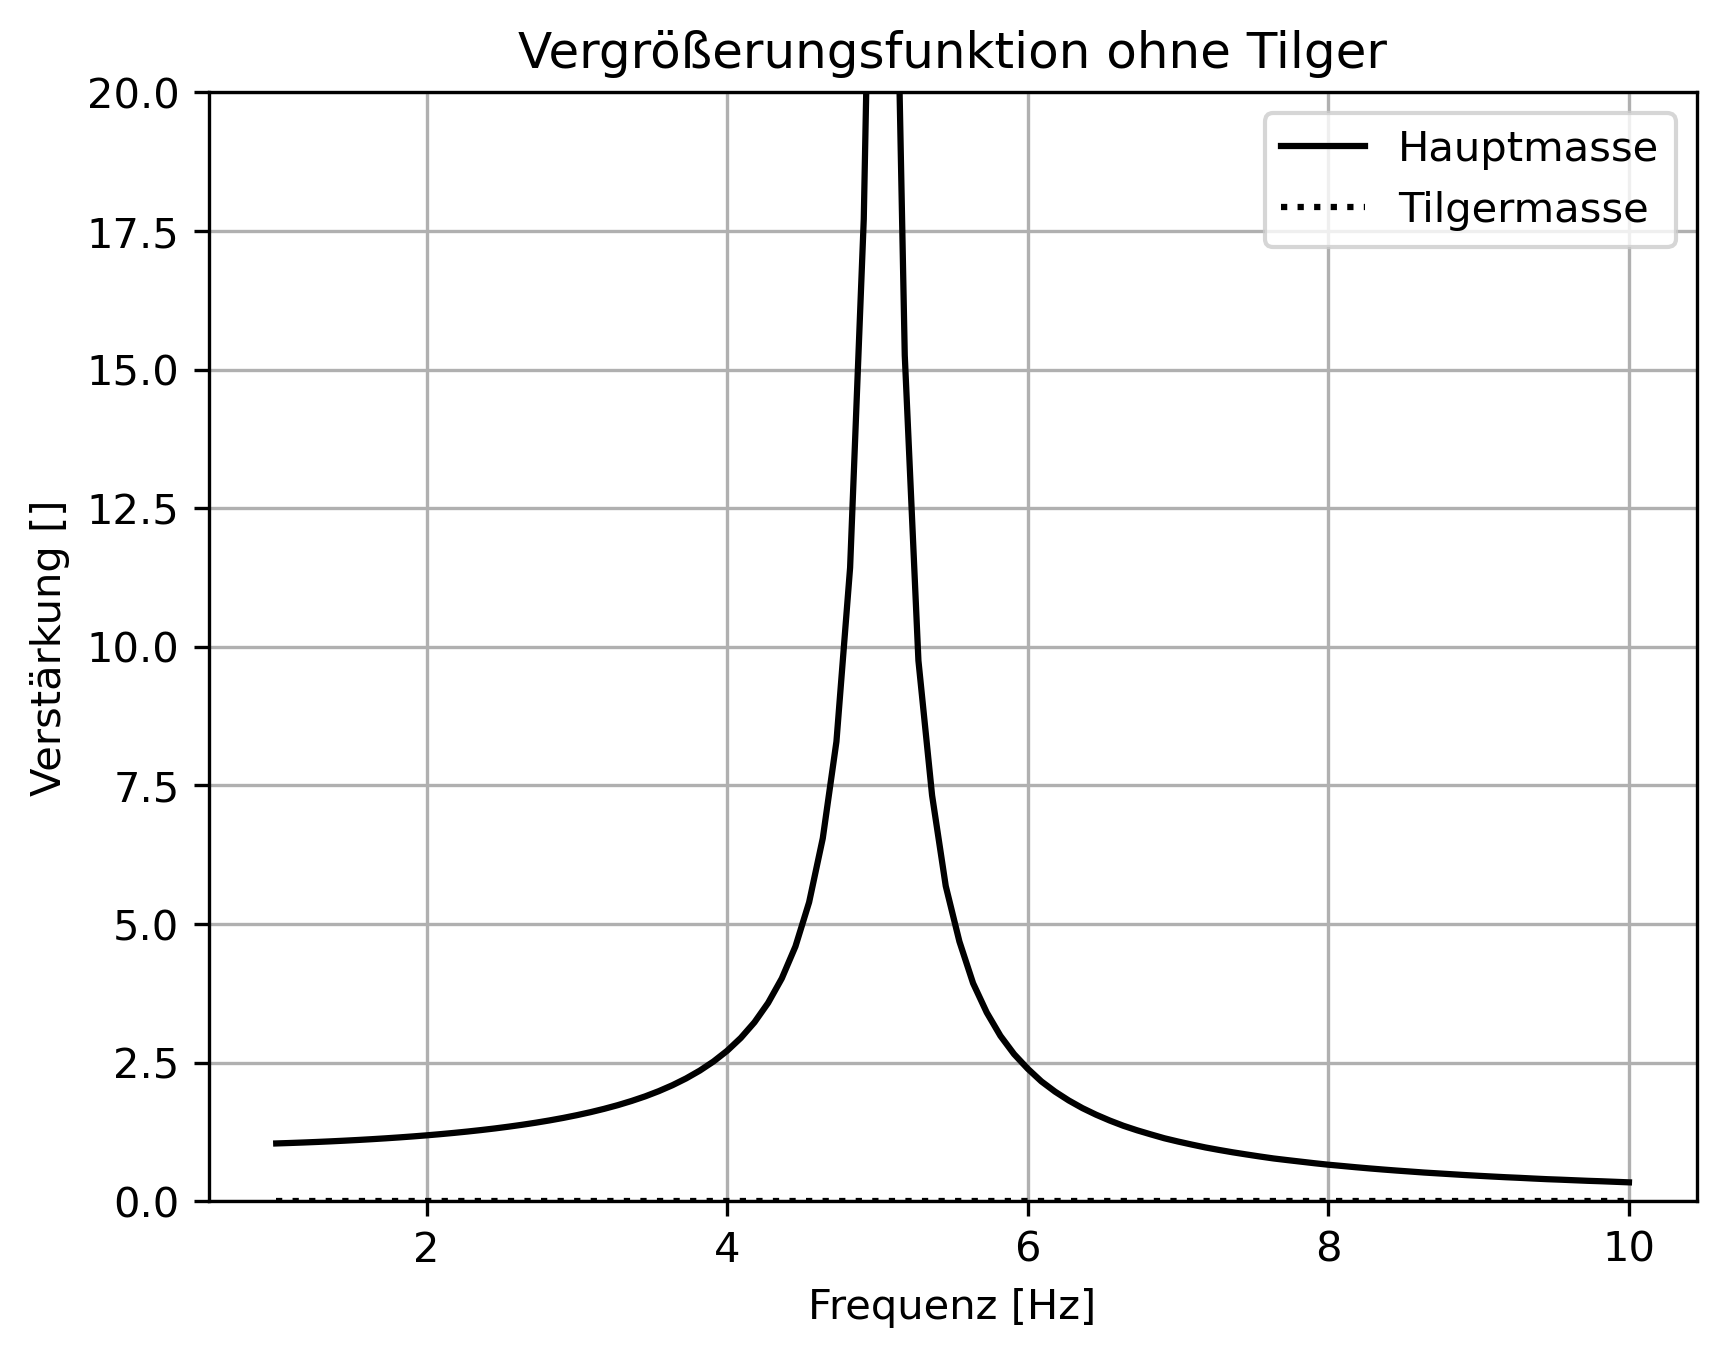

In [33]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.title('Vergrößerungsfunktion ohne Tilger')
plt.plot(datenlogger_f,datenlogger_V_main_1,label='Hauptmasse',color='black')
plt.plot(datenlogger_f,datenlogger_V_tilger_1,label='Tilgermasse',color='black',linestyle='dotted')
plt.ylim(0,20)
#plt.yscale("log")  
plt.xlabel('Frequenz [Hz]')
plt.ylabel(r'Verstärkung []')
plt.grid(True)
plt.legend()
if (Bilder_speichern == True):
    plt.savefig('output_bilder/lsdt_dynasim_schwingungstilger1.png')

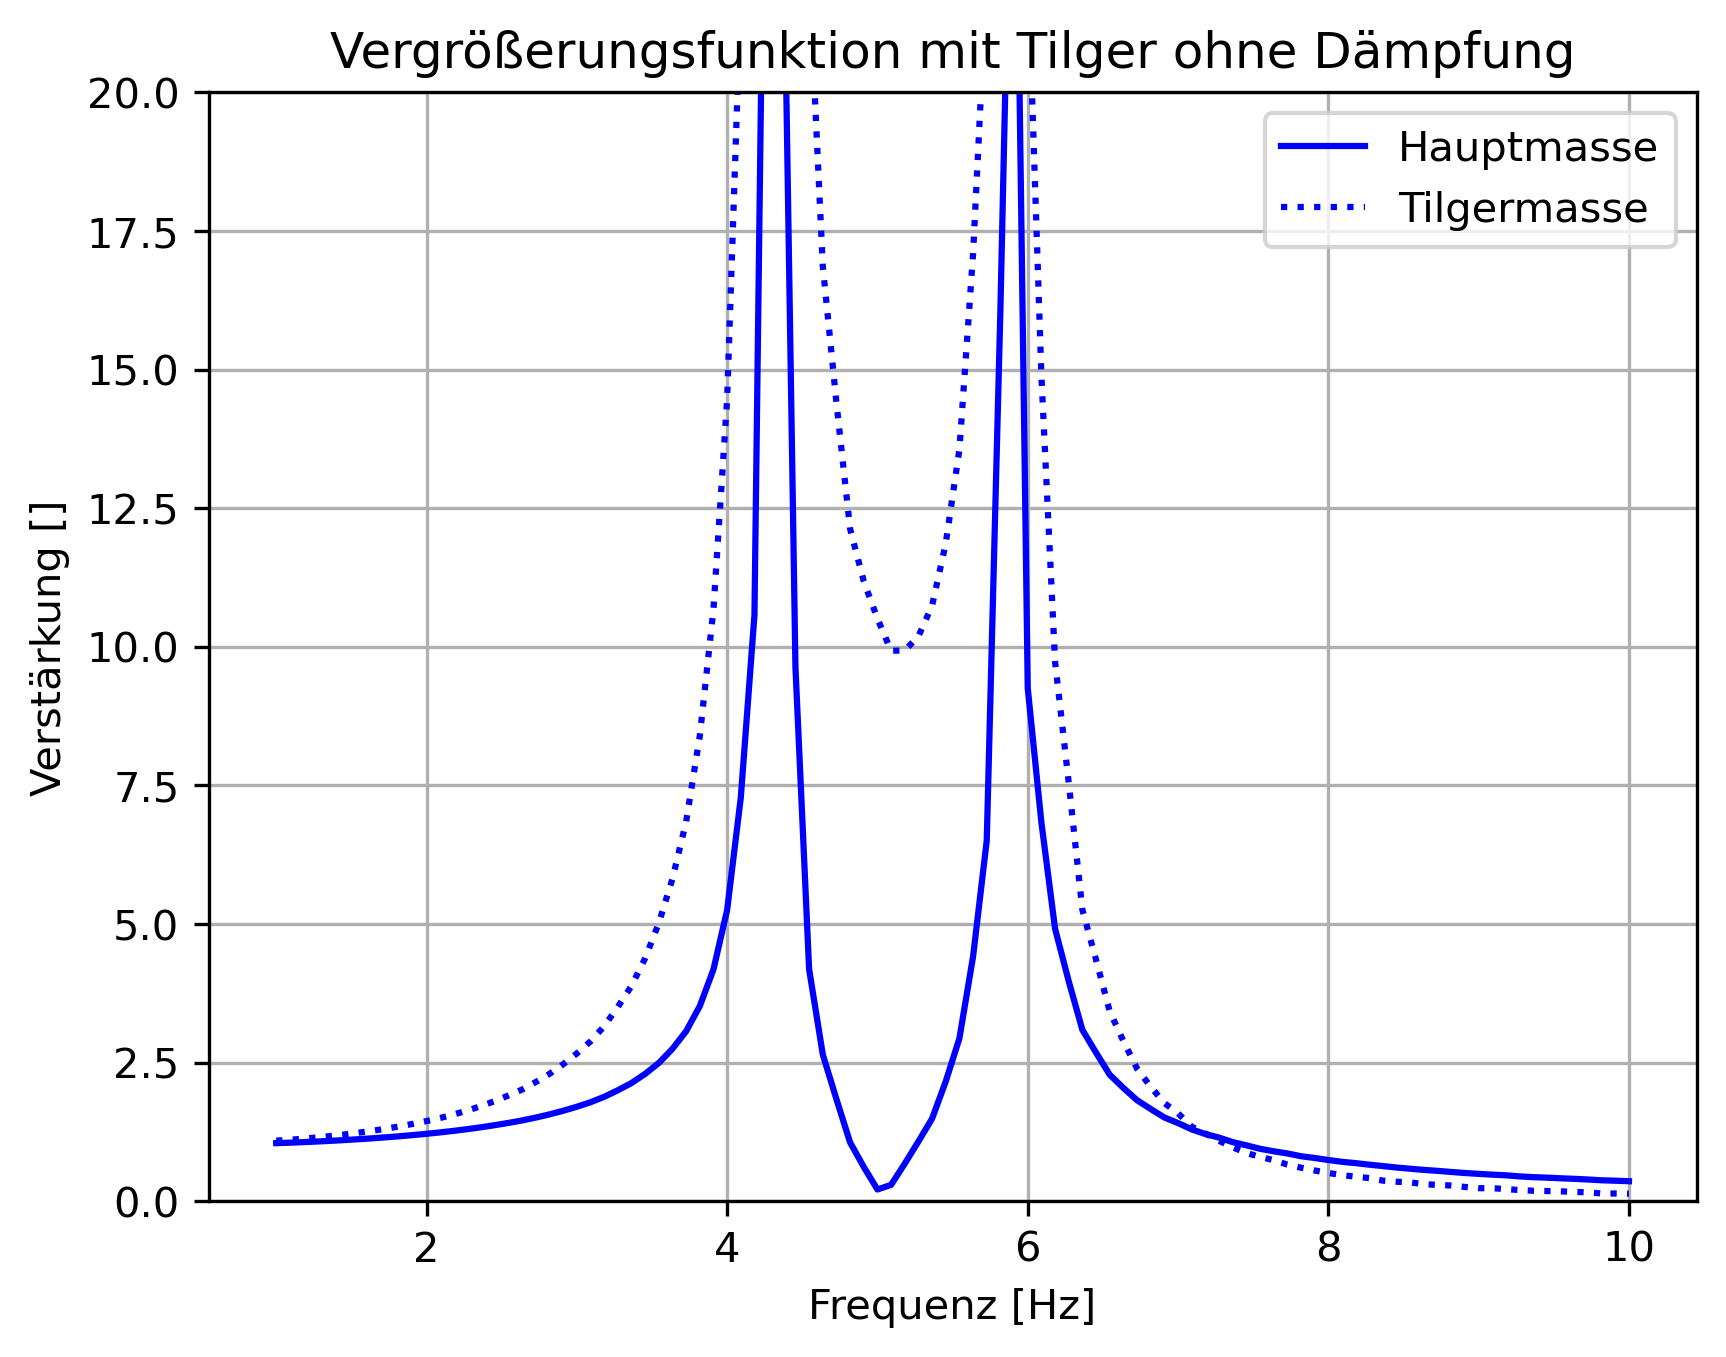

In [34]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.title('Vergrößerungsfunktion mit Tilger ohne Dämpfung')
plt.plot(datenlogger_f,datenlogger_V_main_2,label='Hauptmasse',color='blue')
plt.plot(datenlogger_f,datenlogger_V_tilger_2,label='Tilgermasse',color='blue',linestyle='dotted')
plt.ylim(0,20)
#plt.yscale("log")  
plt.xlabel('Frequenz [Hz]')
plt.ylabel(r'Verstärkung []')
plt.grid(True)
plt.legend()
if (Bilder_speichern == True):
    plt.savefig('output_bilder/lsdt_dynasim_schwingungstilger2.png')

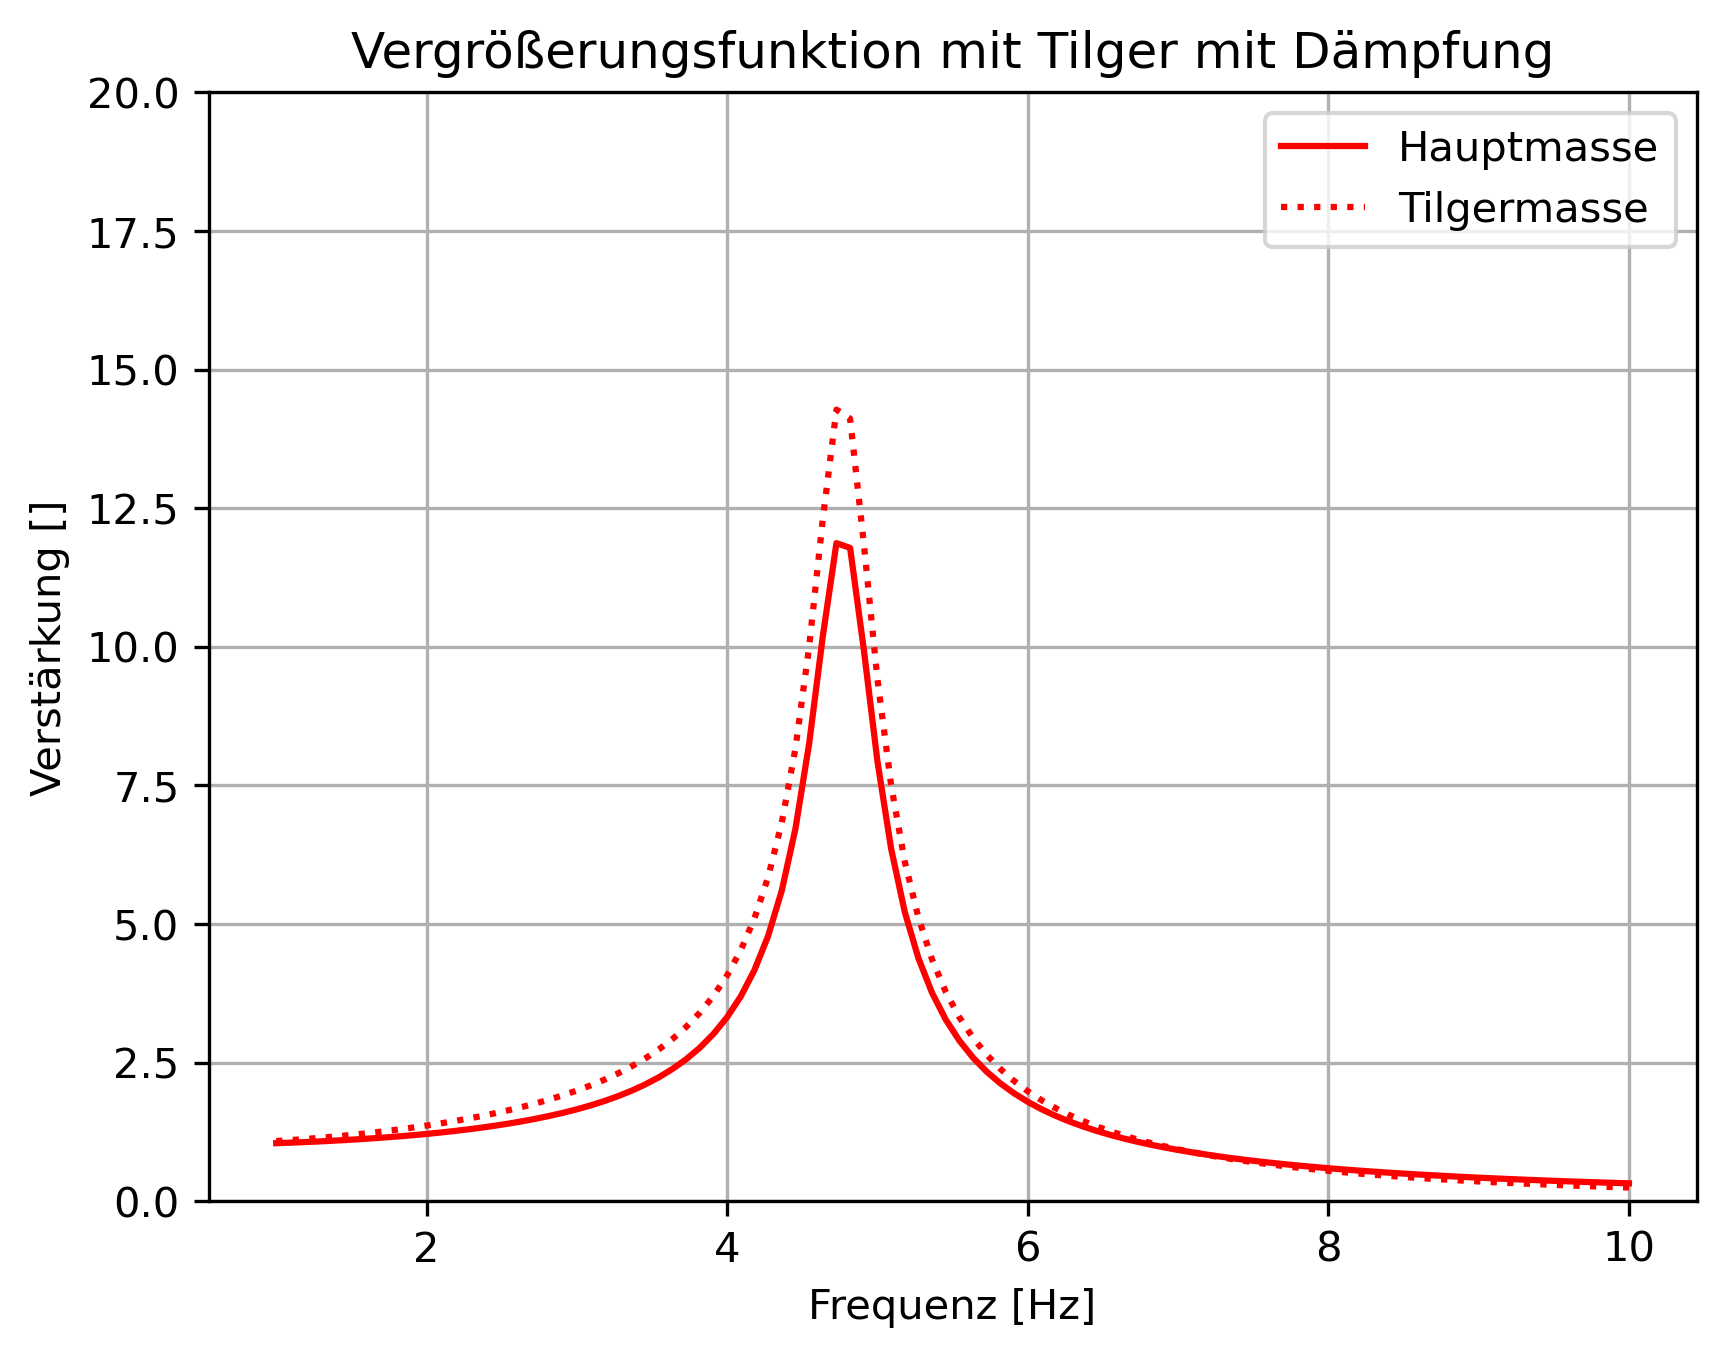

In [35]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.title('Vergrößerungsfunktion mit Tilger mit Dämpfung')
plt.plot(datenlogger_f,datenlogger_V_main_3,label='Hauptmasse',color='red')
plt.plot(datenlogger_f,datenlogger_V_tilger_3,label='Tilgermasse',color='red',linestyle='dotted')
plt.ylim(0,20)
#plt.yscale("log")  
plt.xlabel('Frequenz [Hz]')
plt.ylabel(r'Verstärkung []')
plt.grid(True)
plt.legend()
if (Bilder_speichern == True):
    plt.savefig('output_bilder/lsdt_dynasim_schwingungstilger3.png')

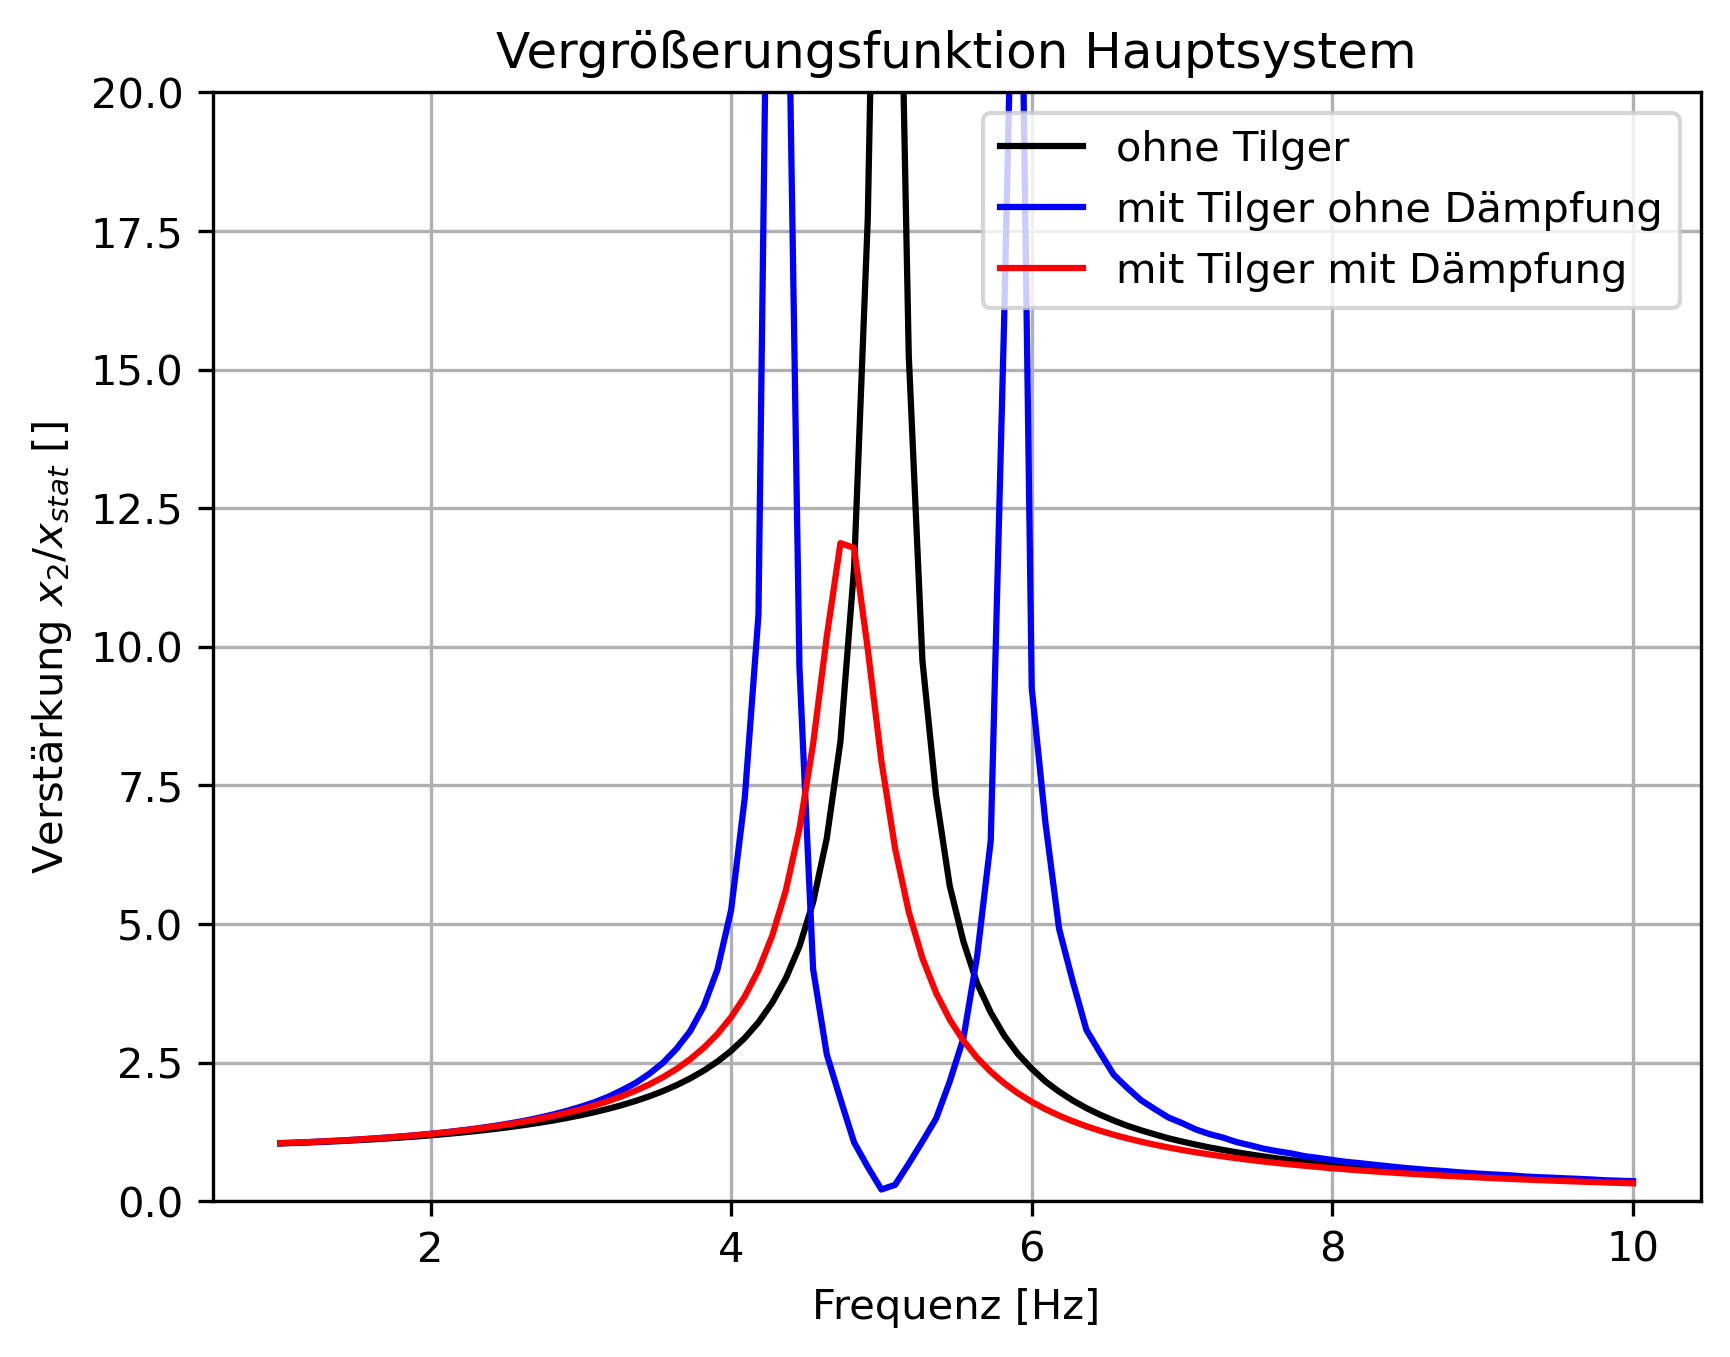

In [36]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.title('Vergrößerungsfunktion Hauptsystem')
plt.plot(datenlogger_f,datenlogger_V_main_1,label='ohne Tilger',color='black')
plt.plot(datenlogger_f,datenlogger_V_main_2,label='mit Tilger ohne Dämpfung',color='blue')
plt.plot(datenlogger_f,datenlogger_V_main_3,label='mit Tilger mit Dämpfung',color='red')
plt.ylim(0,20)
#plt.yscale("log")  
plt.xlabel('Frequenz [Hz]')
plt.ylabel(r'Verstärkung $x_{2} / x_{stat}$ []')
plt.grid(True)
plt.legend()
if (Bilder_speichern == True):
    plt.savefig('output_bilder/lsdt_dynasim_schwingungstilger4.png')

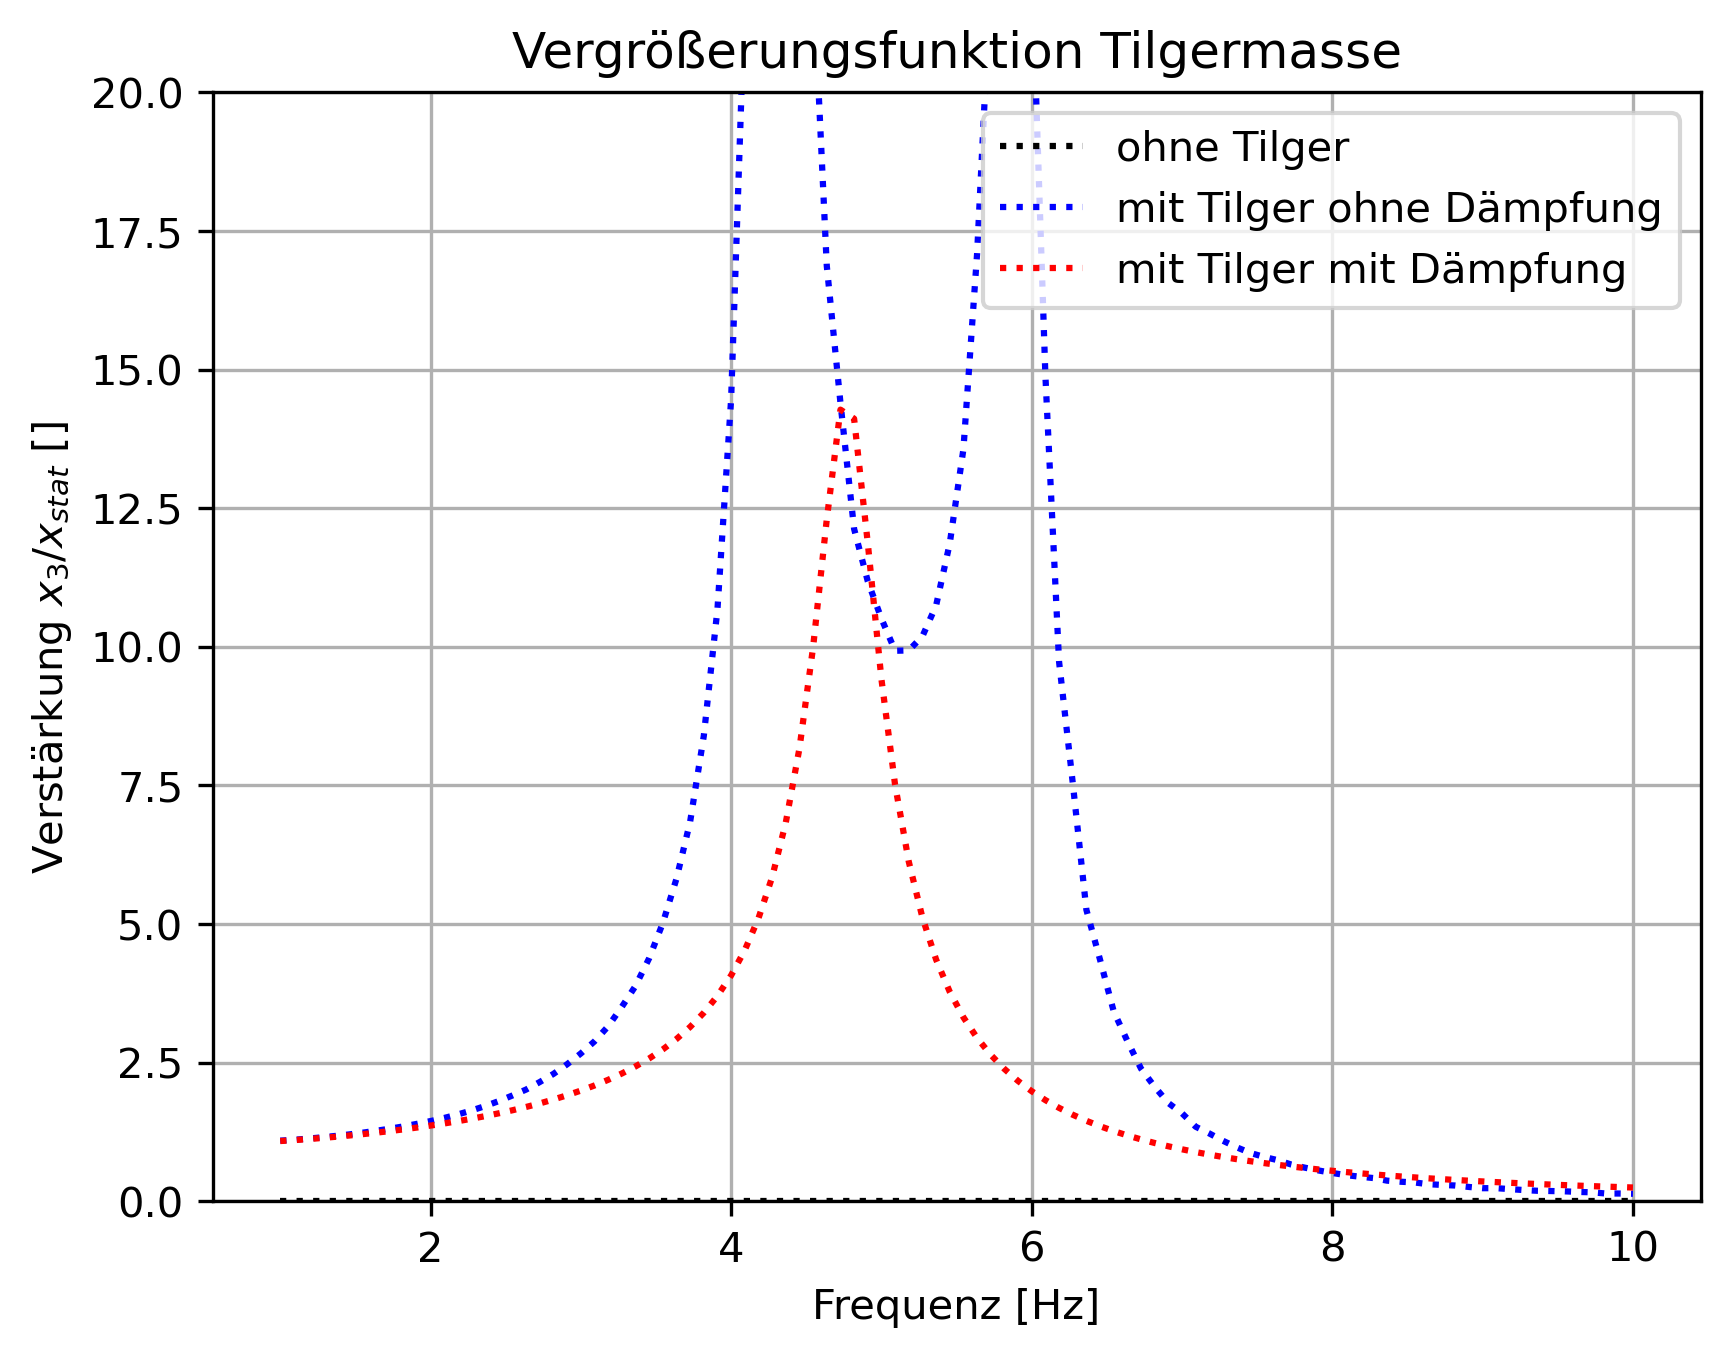

In [37]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.title('Vergrößerungsfunktion Tilgermasse')
plt.plot(datenlogger_f,datenlogger_V_tilger_1,label='ohne Tilger',color='black',linestyle='dotted')
plt.plot(datenlogger_f,datenlogger_V_tilger_2,label='mit Tilger ohne Dämpfung',color='blue',linestyle='dotted')
plt.plot(datenlogger_f,datenlogger_V_tilger_3,label='mit Tilger mit Dämpfung',color='red',linestyle='dotted')
plt.ylim(0,20)
#plt.yscale("log")  
plt.xlabel('Frequenz [Hz]')
plt.ylabel(r'Verstärkung $x_{3} / x_{stat}$ []')
plt.grid(True)
plt.legend()
if (Bilder_speichern == True):
    plt.savefig('output_bilder/lsdt_dynasim_schwingungstilger5.png')